# Deep portfolio Optimization

This commented code contains the model for multiple correlated stocks, based on the initial code for one stock written by Prof. Teichmann. In here you will find the model, the code for generating correlated stocks, the code for strategy dependent interest rates, the code for insider trading. If you wish to see the code for the Vasicek model or the Mean-variance Portfolio Optimisation, please refer yourself to Vasicek notebook (also in the github).

In [1]:
import numpy as np
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Input, Dense, Conv2D, Concatenate, Dropout, Subtract, \
                        Flatten, MaxPooling2D, Multiply, Lambda, Add, Dot
from keras.backend import constant
from keras import optimizers

from keras.models import Model
from keras.layers import Input
from keras import initializers
from keras.constraints import max_norm
import keras.backend as K

import matplotlib.pyplot as plt


Using TensorFlow backend.


In [2]:
#Global parameters

N=30 # time disrectization
S0=1 # initial value of the asset
X0=1  # initial wealth
T=1 # maturity
sigma=0.2 # volatility in Black Scholes
mu=0.1 #drift in Black Scholes
r=0.0 #interest rate
gamma=0 #risk aversion parameter
uncertainty = 0.5 #uncertainty in insider information (u = 0.5 means no insider information)


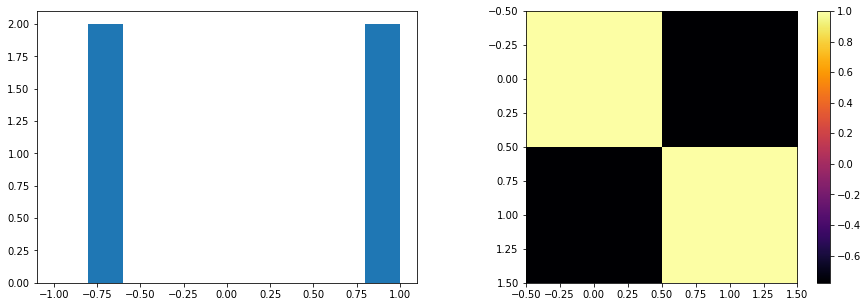

In [3]:
### This cell generates a random correlation matrix
### The plots show the distribution of the correlation coefficients
### This distribution can be toggled by changing the 'a' parameter

import numpy as np
from random import choice
import matplotlib.pyplot as plt
from scipy.linalg import cholesky
from scipy.linalg import lu

n = 2 #size of correlation matrix = number of stocks
a = 0 #parameter for the correlation coefficients distribution

A = np.matrix([np.random.randn(n) + np.random.randn(1)*a for i in range(n)])
A = A*np.transpose(A)
D_half = np.diag(np.diag(A)**(-0.5))
C = D_half*A*D_half

vals = list(np.array(C.ravel())[0])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].hist(vals, range=(-1,1))
img = axes[1].imshow(C, interpolation=None,cmap = 'inferno')
plt.colorbar(img, ax=axes[1])
plt.show()

In [4]:
#Generate a specific desired correlation matrix
#If all stocks are fully correlated or anti-correlated the matrix is no longer positive definite and so
#the Cholesky decomposition cannot be found, so you must define it manually
#In all other cases the Cholesky function returns the appropriate decomposition

m = 20 #number of stocks = size of matrix
rho = 0 #use this in the case m=2
# C = np.array([[1,rho],[rho,1]]) #use this for m=2
C = np.identity(m) #use this for m>2
R = cholesky(C)#np.array([[1,-1],[0,0]])#    #use the fct when possible, otherwise define manually
sigma_vec = np.ones(m)*sigma  #vector of all the volatilities for the stocks (doesn't have to be the same for all)
mu_vec = np.ones(m)*mu #vector of all drifts
print(R)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.

In [5]:
### Here we define the neural networks; one NN for each time step ###

# m = 2 # dimension of price; defined in cell above
d = 3 # number of layers in strategy
n = 32  # nodes in the all but the last layer

# architecture is the same for all networks
layers = []
for j in range(N):
    for i in range(d):
        if i < d-1:
            nodes = n
            layer = Dense(nodes, activation='tanh',trainable=True,
                      kernel_initializer=initializers.RandomNormal(0,0.5),#kernel_initializer='random_normal',
                      bias_initializer=initializers.RandomNormal(0,0.5),
                      name=str(i)+str(j))
        else:
            nodes = m
            layer = Dense(nodes, activation='linear', trainable=True,
                          kernel_initializer=initializers.RandomNormal(0,0.5),#kernel_initializer='random_normal',
                          bias_initializer=initializers.RandomNormal(0,0.5),
                          name=str(i)+str(j))
        layers = layers + [layer]

In [6]:
### Here we implement the evolution in wealth step by step ###
#inputs to our model#
price = Input(shape=(m,))  #initial value of stocks
tradeeval = Input(shape=(m,))   #this parameter will keep track of the strategies so that we can observe them later
wealth = Input(shape=(1,))   #initial wealth

inputs = [price]+[tradeeval]+[wealth]
outputhelper=[] #use these to output information you might want to analyse later
outputhelper2 = [] #These outputs (like tradeeval) are not strictly necessary, the only required output is the final wealth


#Implementation#
for j in range(N):
    incr = Input(shape=(m,)) #another input: at each time step we are given the next increment in price
    
    #use these if no insider trading desired (or just use uncertainty = 0.5)
#     strategy = price
#     strategyeval=tradeeval

    #giving the model insider information on the movement of the stocks at next timestep
    flip = Input(shape=(m,))  #another input: determines whether to give true or false insider info
    insider = Lambda(lambda x: tf.math.sign(x))(incr) #take the sign of next increment
    insider = Multiply()([flip,insider]) #flip the information with proba = uncertainty
    strategy = Lambda(lambda x: tf.concat(x,axis=1))([price,insider]) #vector of current price and insider info on next price
    strategyeval = Lambda(lambda x: tf.concat(x,axis=1))([tradeeval,insider]) #to keep track of strategies
    
    #the NN gives us its strategy based on the current price
    for k in range(d):
        strategy= layers[k+(j)*d](strategy) # strategy at j is the alpha at j 
        strategyeval=layers[k+(j)*d](strategyeval)
        
    #implement an interest rate dependent on strategy    
    helper0a = Lambda(lambda x : K.sum(x,axis=1,keepdims=True))(strategy) #sum over the strategies for all the stocks
    helper0b = Lambda(lambda x: K.less(1.0,x))(helper0a) #is the sum lesser or greater than 1
    helper0b = Lambda(lambda x: tf.cast(x,tf.float32))(helper0b)
    r_t = Lambda(lambda x: x*(mu_vec.mean()-r)*(helper0a - 1)+r)(helper0b) #fct for computing interest rate

#     r_t = r   #use this if no strategy dependent interest rate is desired (you also have to then modify other parts of the code)
        
    #implement price increment
    temp = Lambda(lambda x : x-sigma_vec**2/2*T/N)(incr)
    logprice= Lambda(lambda x : K.log(x))(price)
    logprice = Add()([logprice, temp])
    pricenew=Lambda(lambda x : K.exp(x))(logprice)
    price=pricenew    
    
    #implement most terms of logwealth
    logwealth = Lambda(lambda x : K.log(x))(wealth)
    helperR = Lambda(lambda x : x*T/N)(r_t)
    logwealth = Add()([helperR,logwealth])
    helper1 = Multiply()([strategy, incr])
    helper1 = Lambda(lambda x : K.sum(x,axis=1))(helper1)
    logwealth = Add()([logwealth, helper1])
    helper2 = Lambda(lambda x : K.sum(x,axis=1))(strategy)
    helper2b = Multiply()([r_t, helper2])
    helper2c = Lambda(lambda x : x*T/N)(helper2b)
    logwealth = Subtract()([logwealth, helper2c])
    
    #implement the last rho cross terms
    helper3 = Lambda(lambda x : sigma_vec*x)(strategy) #(none,m) matrix of volatilities*strategies
    helper3t = Lambda(lambda x : K.transpose(x))(helper3) #(m,none)
    
    temp_corr = K.constant(C) #(m,m) correlation matrix
    
    helper4 = Lambda(lambda x : K.dot(x,temp_corr))(helper3) #(none,m)*(m,m) = (none,m)
    helper4 = Lambda(lambda x: tf.einsum('ij,ji->i',x[0], x[1]))([helper4,helper3t]) #(none,m)*(m,none) = (none,none)
    #take only the diag of the (none,none) matrix = (none,)
    
    helper5 = Lambda(lambda x : 1/2*x*T/N)(helper4)
    logwealth = Subtract()([logwealth, helper5])
    
    
    wealthnew=Lambda(lambda x : K.exp(x))(logwealth)# creating the wealth at time j+1
    inputs = inputs + [incr] + [flip] #Note the particular order in which the inputs must be given
    outputhelper = outputhelper + [r_t] + [strategy] # here we collect the interest rates and the strategies
    wealth=wealthnew

outputs = wealth
outputs = [outputs] + outputhelper
outputs = Concatenate()(outputs)

model_Merton_n = Model(inputs=inputs, outputs=outputs)

In [7]:
### Verify that the model works and outputs what you want it to

Ktrain = 3  #number of data points
initialprice = S0
initialwealth = X0
# m = 2


#the following lines show how to implement correlated stock prices and random 'flips' for the insider trading
#Note again the particular ordering of the inputs
uncorr = [np.random.normal(0,np.sqrt(T)/np.sqrt(N),(Ktrain,m)) for i in range(N)] #uncorrelated Brownian Motions
corr = []
for unc in uncorr:
    corr.append(unc@R*sigma_vec+mu_vec*T/N) #correlated stocks
    corr.append(np.random.choice([-1,1],size=(Ktrain,m),p=[uncertainty,1-uncertainty])) #random flips
    
#inputs to our model
xtrain = ([initialprice*np.ones((Ktrain,m))] +
          [np.ones((Ktrain,m))] +
          [initialwealth*np.ones((Ktrain,1))] +
          corr)

#outputs of the model
ytrain = model_Merton_n.predict(xtrain)
print(ytrain.shape)

(3, 631)


In [8]:
###Generate data points; inputs are generated stock prices, outputs are simply 0

Ktrain = 10**5 #number of data points
initialprice = S0
initialwealth = X0

# m = 2
uncorr = [np.random.normal(0,np.sqrt(T)/np.sqrt(N),(Ktrain,m)) for i in range(N)]
corr = []
for unc in uncorr:
    corr.append(unc@R*sigma+mu*T/N)
    corr.append(np.random.choice([-1,1],size=(Ktrain,m),p=[uncertainty,1-uncertainty]))

xtrain = ([initialprice*np.ones((Ktrain,m))] +
          [1*np.ones((Ktrain,m))] +
          [initialwealth*np.ones((Ktrain,1))] +
                 corr)

ytrain=np.zeros((Ktrain,1+N))

In [9]:
###Loss function defined as -1*utility fct

def custom_loss(y_true,y_pred):
    z = - K.log(y_pred[:,0])
#     z = -(y_pred[:,0]**gamma-1)/gamma   #use this if gamma != 0
    z=K.mean(z)
    return z


In [10]:
###Compile the model

from keras import optimizers

adam=optimizers.Adam(lr=0.01)

model_Merton_n.compile(optimizer='adam',loss=custom_loss)

In [11]:
###Train the model

import matplotlib.pyplot as plt

for i in range(1):
    model_Merton_n.fit(x=xtrain,y=ytrain, epochs=2,verbose=True,batch_size=100)

Epoch 1/2
100000/100000 [==============================] - 26s 260us/step - loss: 0.6832
Epoch 2/2
100000/100000 [==============================] - 17s 171us/step - loss: -0.0589


In [12]:
#Generate test data

Ktrain = 10**5
initialprice = S0
initialwealth = X0

# m = 2
uncorr = [np.random.normal(0,np.sqrt(T)/np.sqrt(N),(Ktrain,m)) for i in range(N)]
corr = []
for unc in uncorr:
    corr.append(unc@R*sigma+mu*T/N)
    corr.append(np.random.choice([-1,1],size=(Ktrain,m),p=[uncertainty,1-uncertainty]))

xtrain = ([initialprice*np.ones((Ktrain,m))] +
          [1*np.ones((Ktrain,m))] +
          [initialwealth*np.ones((Ktrain,1))] +
                 corr)

y_pred = model_Merton_n.predict(xtrain)

In [13]:
###This cell gives info on a few select trajectories (might not work if you change too many parameters, outputs etc...)
#Notably you can compare strategies with price increments in the case of insider trading
#Also can see how many times the model has a final wealth lower than the initial wealth

k = 0
info = y_pred[k]
print('y_pred shape:      ', y_pred.shape)
print('final wealth:      ', info[0])
interest = list(info[1+i*3] for i in range(30))
print('r:                 ', interest[0:5])
alpha1 = list(info[2+i*3] for i in range(30))
print('alpha for stock 1: ', alpha1[0:5])
alpha2 = list(info[3+i*3] for i in range(30))
print('alpha for stock 2: ', alpha2[0:5])
temp = np.array(xtrain[3:13:2])
print('stock 1 increment: ', temp[0:5,k,0])
print('stock 2 increment: ', temp[0:5,k,1])

#final wealth under 1
temp = y_pred[:,0]
temp = temp[temp<1]
print('number of final wealths under 1: ',len(temp))

y_pred shape:       (100000, 631)
final wealth:       1.0384978
r:                  [0.04041171, -0.19696681, 0.2176317, -0.12346284, -0.31938705]
alpha for stock 1:  [0.28358322, 0.08934072, 0.3998532, 0.29542798, -0.13690203]
alpha for stock 2:  [-0.123693705, 0.15868105, 0.38716632, -0.21150565, 0.18861252]
stock 1 increment:  [-0.01713573  0.02100632 -0.01580716  0.01906535  0.05707356]
stock 2 increment:  [-0.02366115 -0.02803478 -0.00826334  0.00963337  0.00103368]
number of final wealths under 1:  39072


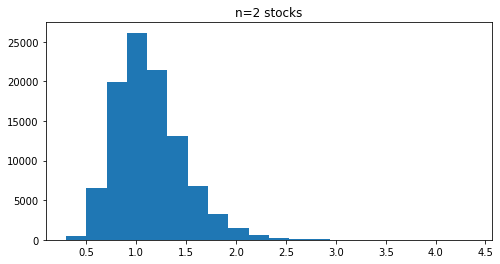

avg final wealth:  1.1306671
standard deviation of final wealth:  0.3379515


In [19]:
###Plot histogram of final wealths

fig, axs = plt.subplots(nrows=1, ncols=1)

axs.hist(y_pred[:,0], bins=20)
axs.title.set_text('n=2 stocks')

fig.set_size_inches(8, 4)
plt.show()

print('avg final wealth: ', np.mean(y_pred[:,0]))
print('standard deviation of final wealth: ', np.std(y_pred[:,0]))

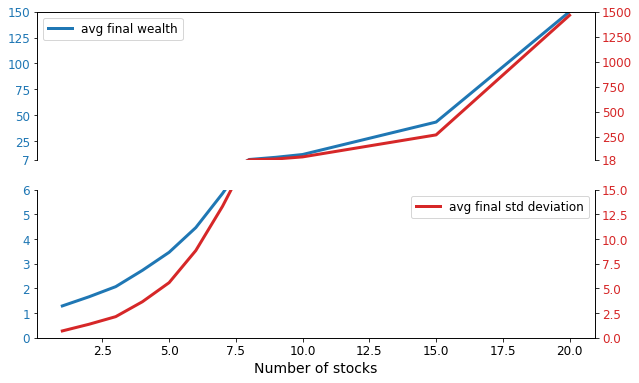

In [124]:
###The following cells were used for plots for the final report and are not particularly relevant or interesting###


x = [1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 15 , 20]
y1 = [1.29 , 1.66 , 2.07 , 2.73 , 3.46 , 4.46 , 5.84 , 7.38 , 9.51 , 12.2 , 43.5 , 150]
y2 = [0.695 , 1.37 , 2.14 , 3.65 , 5.58 , 8.83 , 13.3 , 18.5 , 27.2 , 48.0 , 268 , 1464]

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 28

plt.rc('lines', linewidth=3)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title


#plot the different fluxes
fig, axs = plt.subplots(nrows=2, ncols=1)

color = 'tab:blue'
y1temp = [-10 if y<6 else y for y in y1]
axs[0].plot(x,y1temp,color=color,label='avg final wealth')
axs[1].plot(x,y1,color=color)
axs[0].tick_params(axis='y', labelcolor=color)
axs[1].tick_params(axis='y', labelcolor=color)

  # instantiate a second axes that shares the same x-axis
axs2 = [axs[0].twinx(), axs[1].twinx()]
color = 'tab:red'
y2temp = [-100 if y<15 else y for y in y2]        
axs2[1].plot(x,y2,color=color,label = 'avg final std deviation')
axs2[0].plot(x,y2temp,color=color)
axs2[0].tick_params(axis='y', labelcolor=color)
axs2[1].tick_params(axis='y', labelcolor=color)

axs[0].set_ylim(7,150)  # outliers only
axs[1].set_ylim(0,6)  # most of the data
axs2[0].set_ylim(18,1500)  # outliers only
axs2[1].set_ylim(0,15)  # most of the data

# hide the spines between ax and ax2
axs[0].spines['bottom'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[0].xaxis.tick_top()
axs[0].tick_params(top=0,labeltop=0)  # don't put tick labels at the top
axs[1].xaxis.tick_bottom()
axs2[0].spines['bottom'].set_visible(False)
axs2[1].spines['top'].set_visible(False)
axs2[0].xaxis.tick_top()
axs2[0].tick_params(top=0,labeltop=0)  # don't put tick labels at the top
axs2[1].xaxis.tick_bottom()

# d = .015  # how big to make the diagonal lines in axes coordinates
# # arguments to pass to plot, just so we don't keep repeating them
# kwargs = dict(transform=axs[0].transAxes, color='k', clip_on=False)
# axs[0].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
# axs[0].plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

# kwargs.update(transform=axs[1].transAxes)  # switch to the bottom axes
# axs[1].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
# axs[1].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal
# kwargs = dict(transform=axs2[0].transAxes, color='k', clip_on=False)
# axs2[0].plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
# axs2[0].plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

# kwargs.update(transform=axs2[1].transAxes)  # switch to the bottom axes
# axs2[1].plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
# axs2[1].plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

fig.set_size_inches(10,6)
fig.canvas.draw()
locs = axs[0].get_yticks()
labels = axs[0].get_yticklabels()
locs[0] = 7
labels[0] = '7'
axs[0].set_yticks(locs)
axs[0].set_yticklabels(labels)
locs = axs2[0].get_yticks()
labels = axs2[0].get_yticklabels()
locs[0] = 18
labels[0] = '18'
axs2[0].set_yticks(locs)
axs2[0].set_yticklabels(labels)


# labels = [item.get_text() for item in axs[0].get_yticklabels()]
# labels[-1] = 'infinity'
# axs[0].set_yticklabels(labels)
# labels2 = [item.get_text() for item in axs2[0].get_yticklabels()]
# labels2[-1] = 'infinity'
# axs2[0].set_yticklabels(labels2)

axs[0].legend()
axs2[1].legend()
axs[1].set_xlabel(r'Number of stocks')

plt.show()

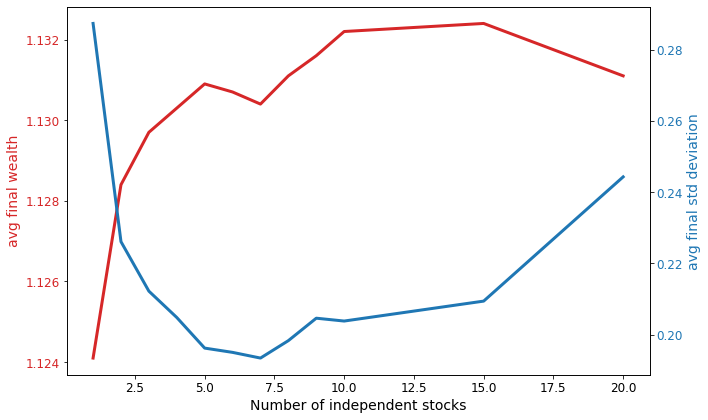

In [144]:
x = [1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 15 , 20]
y1 = [1.1241 , 1.1284 , 1.1297 , 1.1303 , 1.1309 , 1.1307 , 1.1304 , 1.1311 , 1.1316 , 1.1322 , 1.1324 , 1.1311]
y2 = [0.2874 , 0.2261 , 0.2122 , 0.2048 , 0.1962 , 0.1950 , 0.1934 , 0.1983 , 0.2046 , 0.2038 , 0.2094 , 0.2443]

fig, ax1 = plt.subplots()
fig.set_size_inches(10,6)
color = 'tab:red'
ax1.set_xlabel(r'Number of independent stocks')
ax1.set_ylabel('avg final wealth', color=color)
ax1.plot(x, y1, color=color)
# ax1.set_yticks(np.arange(min(y1), max(y1)+0.001, 0.002))
ax1.tick_params(axis='y', labelcolor=color)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('avg final std deviation', color=color)  # we already handled the x-label with ax1
ax2.plot(x, y2, color=color)
# ax2.set_yticks(np.arange(min(y2), max(y2)+0.05, 0.05))
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()